<a href="https://colab.research.google.com/github/shumshersubashgautam/Computer-Aided-Drug-Discovery-Learning/blob/main/34_%C2%B7_RNN_based_molecular_property_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/volkamerlab/teachopencadd.git

Cloning into 'teachopencadd'...
remote: Enumerating objects: 17115, done.
remote: Counting objects: 100% (2094/2094), done.
remote: Compressing objects: 100% (971/971), done.
remote: Total 17115 (delta 1311), reused 1784 (delta 1121), pack-reused 15021
Receiving objects: 100% (17115/17115), 849.73 MiB | 32.24 MiB/s, done.
Resolving deltas: 100% (11503/11503), done.
Updating files: 100% (468/468), done.


In [3]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 50.0 MB/s eta 0:00:00


Molecules as text

Tokenization and one-hot encoding

Recurrent Neural Networks (RNNs)

Vanilla RNN

Training an RNN

Vanishing gradients

Gated Recurrent Unit

In [52]:
import os
import re
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset

In [53]:
# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# seed random generator
_ = torch.manual_seed(42)

In [54]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [56]:
# load the dataset
df = pd.read_csv(os.path.join(DATA, "/content/teachopencadd/teachopencadd/talktorials/T034_recurrent_neural_networks/data/qm9.csv.gz"), compression="gzip")
df.head()


,mol_id,A,B,C,mu,alpha,homo,lumo,gap,r2,...,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom,smiles
0,gdb_1,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,...,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772,C
1,gdb_2,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,...,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802,N
2,gdb_3,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,...,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171,O
3,gdb_4,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,...,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724,C#C
4,gdb_5,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,...,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028,C#N


In [57]:
class SmilesTokenizer(object):
    """
    A simple regex-based tokenizer adapted from the deepchem smiles_tokenizer package.
    SMILES regex pattern for the tokenization is designed by Schwaller et. al., ACS Cent. Sci 5 (2019)
    """

    def __init__(self):
        self.regex_pattern = (
            r"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\."
            r"|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"
        )
        self.regex = re.compile(self.regex_pattern)

    def tokenize(self, smiles):
        """
        Tokenizes SMILES string.

        Parameters
        ----------
        smiles : str
            Input SMILES string.

        Returns
        -------
        List[str]
            A list of tokens.
        """
        tokens = [token for token in self.regex.findall(smiles)]
        return tokens

In [58]:
def build_vocab(smiles_list, tokenizer, max_vocab_size):
    """
    Builds a vocabulary of N=max_vocab_size most common tokens from list of SMILES strings.

    Parameters
    ----------
    smiles_list : List[str]
        List of SMILES strings.
    tokenizer : SmilesTokenizer
    max_vocab_size : int
        Maximum size of vocabulary.

    Returns
    -------
    Dict[str, int]
        A dictionary that defines mapping of a token to its index in the vocabulary.
    """
    tokenized_smiles = [tokenizer.tokenize(s) for s in smiles_list]
    token_counter = Counter(c for s in tokenized_smiles for c in s)
    tokens = [token for token, _ in token_counter.most_common(max_vocab_size)]
    vocab = {token: idx for idx, token in enumerate(tokens)}
    return vocab


def smiles_to_ohe(smiles, tokenizer, vocab):
    """
    Transforms SMILES string to one-hot encoding representation.

    Parameters
    ----------
    smiles : str
        Input SMILES string.
    tokenizer : SmilesTokenizer
    vocab : Dict[str, int]
        A dictionary that defines mapping of a token to its index in the vocabulary.

    Returns
    -------
    Tensor
        A pytorch Tensor with shape (n_tokens, vocab_size), where n_tokens is the
        length of tokenized input string, vocab_size is the number of tokens in
        the vocabulary
    """
    unknown_token_id = len(vocab) - 1
    token_ids = [vocab.get(token, unknown_token_id) for token in tokenizer.tokenize(smiles)]
    ohe = torch.eye(len(vocab))[token_ids]
    return ohe

In [59]:
tokenizer = SmilesTokenizer()

smiles = "C=CCl"
print("SMILES string:\n\t", smiles)
print("Tokens:\n\t", ", ".join(tokenizer.tokenize(smiles)))
vocab = build_vocab([smiles], tokenizer, 3)
print("Vocab:\n\t", vocab)
print("OHE:\n", np.array(smiles_to_ohe(smiles, tokenizer, vocab)).T)

SMILES string:
	 C=CCl
Tokens:
	 C, =, C, Cl
Vocab:
	 {'C': 0, '=': 1, 'Cl': 2}
OHE:
 [[1. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


In [60]:
sample_size = 50000
n_train = 40000
n_test = n_val = 5000

# get a sample
df = df.sample(n=sample_size, axis=0, random_state=42)

# select columns from the data frame
smiles = df["smiles"].tolist()
y = df["mu"].to_numpy()

# build a vocab using the training data
max_vocab_size = 30
vocab = build_vocab(smiles[:n_train], tokenizer, max_vocab_size)
vocab_size = len(vocab)

# transform smiles to one-hot encoded tensors and apply padding
X = pad_sequence(
    sequences=[smiles_to_ohe(smi, tokenizer, vocab) for smi in smiles],
    batch_first=True,
    padding_value=0,
)

# normalize the target using the training data
train_mean = y[:n_train].mean()
train_std = y[:n_train].std()
y = (y - train_mean) / train_std

# build dataset
data = TensorDataset(X, torch.Tensor(y))

# define loaders
ids_train = np.arange(n_train)
ids_val = np.arange(n_val) + n_train
ids_test = np.arange(n_test) + n_train + n_val
train_loader = DataLoader(
    Subset(data, ids_train),
    batch_size=64,
    shuffle=True,
    generator=torch.Generator().manual_seed(42),
)
val_loader = DataLoader(
    Subset(data, ids_val), batch_size=64, shuffle=True, generator=torch.Generator().manual_seed(42)
)
test_loader = DataLoader(
    Subset(data, ids_test),
    batch_size=1,
    shuffle=False,
    generator=torch.Generator().manual_seed(42),
)

In [61]:
class RNNRegressionModel(nn.Module):
    """Vanilla RNN with one recurrent layer"""

    def __init__(self, input_size, hidden_size=32, num_layers=1):
        """
        Vanilla RNN

        Parameters
        ----------
        input_size : int
            The number of expected features in the input vector
        hidden_size : int
            The number of features in the hidden state

        """
        super(RNNRegressionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, hn = self.rnn(x, h0)
        out = out[:, -1]
        out = self.dropout(out)
        out = self.fc(out)
        return out


class GRURegressionModel(nn.Module):
    """GRU network with one recurrent layer"""

    def __init__(self, input_size, hidden_size=32, num_layers=1):
        """
        GRU network

        Parameters
        ----------
        input_size : int
            The number of expected features in the input vector
        hidden_size : int
            The number of features in the hidden state

        """
        super(GRURegressionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, hn = self.gru(x, h0)
        out = out[:, -1]
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [67]:
class ModelTrainer(object):
    """A class that provides training and validation infrastructure for the model and keeps track of training and validation metrics."""

    def __init__(self, model, lr, name=None, clip_gradients=False):
        """
        Initialization.

        Parameters
        ----------
        model : nn.Module
            a model
        lr : float
            learning rate for one training step

        """
        self.model = model
        self.lr = lr
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr)
        self.clip_gradients = clip_gradients
        self.model.to(device)

        self.train_loss = []
        self.batch_loss = []
        self.val_loss = []

    def _train_epoch(self, loader):
        self.model.train()
        epoch_loss = 0
        batch_losses = []
        for i, (X_batch, y_batch) in enumerate(loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            self.optimizer.zero_grad()
            y_pred = self.model(X_batch)
            loss = self.criterion(y_pred, y_batch.unsqueeze(1))
            loss.backward()

            if self.clip_gradients:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1, norm_type=2)

            self.optimizer.step()
            epoch_loss += loss.item()
            batch_losses.append(loss.item())

        return epoch_loss / len(loader), batch_losses

    def _eval_epoch(self, loader):
        self.model.eval()
        val_loss = 0
        predictions = []
        targets = []
        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = self.model(X_batch)
                loss = self.criterion(y_pred, y_batch.unsqueeze(1))
                val_loss += loss.item()
                predictions.append(y_pred.detach().cpu().numpy())
                targets.append(y_batch.unsqueeze(1).detach().cpu().numpy())

        predictions = np.concatenate(predictions).flatten()
        targets = np.concatenate(targets).flatten()
        return val_loss / len(loader), predictions, targets

    def train(self, train_loader, val_loader, n_epochs, print_every=10):
        """
        Train the model

        Parameters
        ----------
        train_loader :
            a dataloader with training data
        val_loader :
            a dataloader with training data
        n_epochs :
            number of epochs to train for
        """
        for e in range(n_epochs):
            train_loss, train_loss_batches = self._train_epoch(train_loader)
            val_loss, _, _ = self._eval_epoch(test_loader)
            self.batch_loss += train_loss_batches
            self.train_loss.append(train_loss)
            self.val_loss.append(val_loss)
            if e % print_every == 0:
                print(f"Epoch {e+0:03} | train_loss: {train_loss:.5f} | val_loss: {val_loss:.5f}")

    def validate(self, val_loader):
        """
        Validate the model

        Parameters
        ----------
        val_loader :
            a dataloader with training data

        Returns
        -------
        Tuple[list, list, list]
            Loss, y_predicted, y_target for each datapoint in val_loader.
        """
        loss, y_pred, y_targ = self._eval_epoch(val_loader)
        return loss, y_pred, y_targ

In [68]:
model_rnn = ModelTrainer(
    model=RNNRegressionModel(vocab_size, hidden_size=32),
    lr=1e-3,
)

In [74]:
model_gru = ModelTrainer(
    model=GRURegressionModel(vocab_size, hidden_size=32),
    lr=1e-3,
)

In [69]:
model_rnn.train(train_loader, val_loader, 51)

Epoch 000 | train_loss: 0.85954 | val_loss: 0.63604
Epoch 010 | train_loss: 0.55200 | val_loss: 0.50211
Epoch 020 | train_loss: 0.49238 | val_loss: 0.44084
Epoch 030 | train_loss: 0.45500 | val_loss: 0.41160
Epoch 040 | train_loss: 0.43041 | val_loss: 0.40063
Epoch 050 | train_loss: 0.41760 | val_loss: 0.39637


In [75]:
model_gru.train(train_loader, val_loader, 51)

Epoch 000 | train_loss: 0.75208 | val_loss: 0.54450
Epoch 010 | train_loss: 0.43109 | val_loss: 0.42034
Epoch 020 | train_loss: 0.37559 | val_loss: 0.38635
Epoch 030 | train_loss: 0.34615 | val_loss: 0.35569
Epoch 040 | train_loss: 0.32072 | val_loss: 0.34151
Epoch 050 | train_loss: 0.30018 | val_loss: 0.34079


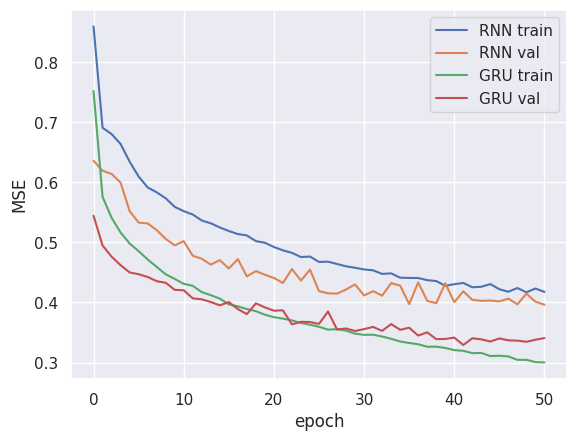

In [76]:
plt.plot(model_rnn.train_loss, label=f"RNN train")
plt.plot(model_rnn.val_loss, label=f"RNN val")
plt.plot(model_gru.train_loss, label=f"GRU train")
plt.plot(model_gru.val_loss, label=f"GRU val")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()

RNN test loss: 0.396
GRU test loss: 0.341


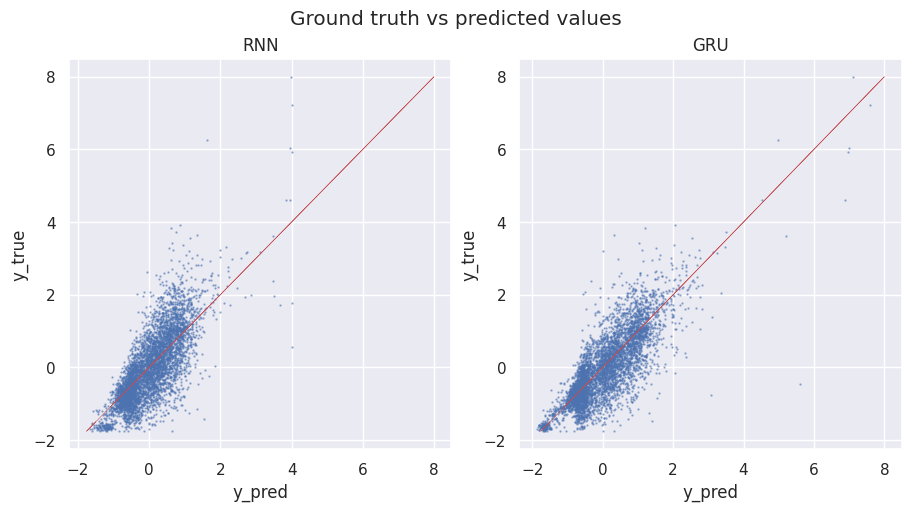

In [77]:
f, axarr = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)

f.suptitle("Ground truth vs predicted values")

loss, y_pred, y_targ = model_rnn.validate(test_loader)
print(f"RNN test loss: {loss:.3f}")

_ = axarr[0].scatter(y_pred, y_targ, alpha=0.5, s=0.5)
_ = axarr[0].plot(y_targ, y_targ, lw=0.4, c="r")
_ = axarr[0].set_title("RNN")

loss, y_pred, y_targ = model_gru.validate(test_loader)
print(f"GRU test loss: {loss:.3f}")

_ = axarr[1].scatter(y_pred, y_targ, alpha=0.5, s=0.5)
_ = axarr[1].plot(y_targ, y_targ, lw=0.4, c="r")
_ = axarr[1].set_title("GRU")

for ax in axarr:
    _ = ax.set_xlabel("y_pred")
    _ = ax.set_ylabel("y_true")

**Discussion**
Natural language processing-based models proved to be a powerful tool for a wide range of molecular tasks. In this talktorial we introduced the basics of Recurrent Neural Network architectures and demonstrated their application to the regression task on the QM9 dataset. We have learned how to pre-process SMILES strings, build a model using PyTorch, and train the model to predict the dipole moment of the molecule.